# Tag preparation
Because the tags of each video consists of a sub-list they cannot be directly integrated into most models.
The idea to allow the usage of tags inside the model without using specialized or complex algorithms is to condense them down to a single value.
For this reason we developed our own algorithm to calculate a factor between 0 and 1
that describes the relation of how close a single tag is related to the *trending category* of a video.
The *trending category* has been directly obtained from the data understanding phase.

The processing of list based data was implemented with the help of [this](https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173) article.

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry

from datetime import datetime

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 6)

## Configuration Parameter
List of parameters used to configure the algorithm and usage of data.
Change the *data_lan_code* to perform the calculation for different regions.

In [67]:
data_lan_code = 'DE'

filter_countries = True
filter_languages = False # Resource intensive, use with care

#limit_method = 'count'
#limit_method = 'percent'
limit_method = None
max_tag_count = 100
max_tag_percent = 0.5

# Always applied after tag limit calculation
filter_tags_by_usage = True
min_tag_usage = 20

# Prepare data
Loading of the data specified in the configuration section as well as calculation of the
*trending category* that is required for later calculation. Columns that are not required will be
dropped to reduce memory usage.

In [68]:
df = pd.read_csv('../0_data/'+ data_lan_code + 'videos.csv')

def assign_trending_category(row):
    if row['days_until_trending'] == 0:
        return 0 # 0 Days
    elif row['days_until_trending'] == 1:
        return 1 # 1 Day
    elif row['days_until_trending'] == 2:
        return 2 # 2 Days
    elif row['days_until_trending'] <= 5:
        return 3 # 3 - 5 Days
    else:
        return 4 # > 5 Days

df['days_until_trending'] = df.apply(lambda x: ((datetime.strptime(x['trending_date'], '%y.%d.%m') - datetime.strptime(x['publish_time'], '%Y-%m-%dT%H:%M:%S.000Z')).days + 1), axis=1)
df['trending_category'] = df.apply(assign_trending_category, axis=1)

df = df.drop(['trending_date','category_id', 'publish_time', 'views', 'likes','dislikes',
         'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled',
         'video_error_or_removed', 'description', 'days_until_trending',
          'channel_title'], axis=1)
df.head()

,video_id,title,tags,trending_category
0,2kyS6SvSYSE,WE WANT TO TALK ABOUT OUR MARRIAGE,SHANtell martin,1
1,1ZAPwfrtAFY,The Trump Presidency: Last Week Tonight with J...,"last week tonight trump presidency|""last week ...",1
2,5qpjK5DgCt4,"Racist Superman | Rudy Mancuso, King Bach & Le...","racist superman|""rudy""|""mancuso""|""king""|""bach""...",2
3,puqaWrEC7tY,Nickelback Lyrics: Real or Fake?,"rhett and link|""gmm""|""good mythical morning""|""...",1
4,d380meD0W0M,I Dare You: GOING BALD!?,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2


### Parse tags and convert
The tags cannot be used as they are provided by the data because the are stored as a single string.
Therefore, additional parsing and formatting is required to convert them to a list that can be used by Python.

The following formatting is applied:
* Remove enclosing quotation marks ("")
* convert to lower case
* remove duplicates (due to conversion to lower)

One goal of the tag preparation is to be independent of time and location therefore additional filtering is required.

Tags will be excluded when:
* The tag matches the '[none]' tag (Video has no tags assigned)
* The tag is a number (to remove time related data like years)
* The tag describes a country
* The tag describes a language (resource intensive due to large amount of languages)

To filter languages and countries a special package called [pycountry](https://pypi.org/project/pycountry/) is used.

In [69]:
countries = [s.name for s in pycountry.countries]
languages = [s.name for s in pycountry.languages]

def isValidTag(s):
    return s != '[none]' \
    and not s.isnumeric() \
    and not(filter_countries and s in countries) \
    and not (filter_languages and s in languages)
def formatData(s):
    s2 = map(lambda x: x.strip('\"').lower(), s)
    res = []
    [res.append(x) for x in s2 if x not in res]
    return res

df['parsed_tags'] = df['tags'].str.split('|')\
    .apply(formatData)\
    .apply(lambda x: list(filter(isValidTag, x)))
df = df.drop('tags', axis=1)
df['parsed_tags'].head()


0                                    [shantell martin]
1    [last week tonight trump presidency, last week...
2    [racist superman, rudy, mancuso, king, bach, r...
3    [rhett and link, gmm, good mythical morning, r...
4    [ryan, higa, higatv, nigahiga, i dare you, idy...
Name: parsed_tags, dtype: object

## Calculate tag count per video

In [70]:
df['tag_count'] = df.apply( lambda x: len(x['parsed_tags']), axis=1)
df.head()

,video_id,title,trending_category,parsed_tags,tag_count
0,2kyS6SvSYSE,WE WANT TO TALK ABOUT OUR MARRIAGE,1,[shantell martin],1
1,1ZAPwfrtAFY,The Trump Presidency: Last Week Tonight with J...,1,"[last week tonight trump presidency, last week...",4
2,5qpjK5DgCt4,"Racist Superman | Rudy Mancuso, King Bach & Le...",2,"[racist superman, rudy, mancuso, king, bach, r...",23
3,puqaWrEC7tY,Nickelback Lyrics: Real or Fake?,1,"[rhett and link, gmm, good mythical morning, r...",27
4,d380meD0W0M,I Dare You: GOING BALD!?,2,"[ryan, higa, higatv, nigahiga, i dare you, idy...",14


## Utility data
This section is not necessary for the calculation and only displays some statistical information.


### Total number of tags

In [71]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])
tag_counts = to_1D(df['parsed_tags']).value_counts()
tag_counts.name = "counts"
tag_counts.sum()

800146

### Most used tags

<AxesSubplot:>

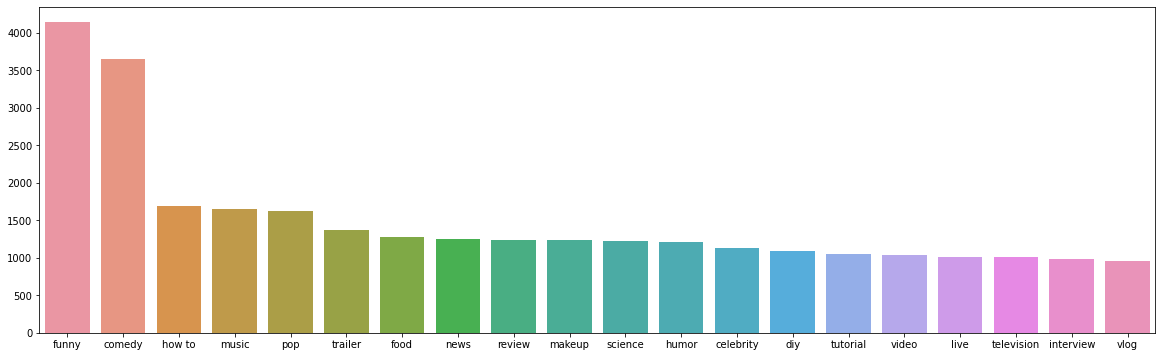

In [72]:
top_tags = tag_counts.head(20)
sns.barplot(x=top_tags.index, y=top_tags.values)

## Tags as correlation matrix
Disclaimer: The calculation of the binary table over the given tag data can be quite resource intensive.
It is recommended to not use to large values for *tags_start* and *tags_end* because the required calculation
time grows quite fast.

<AxesSubplot:>

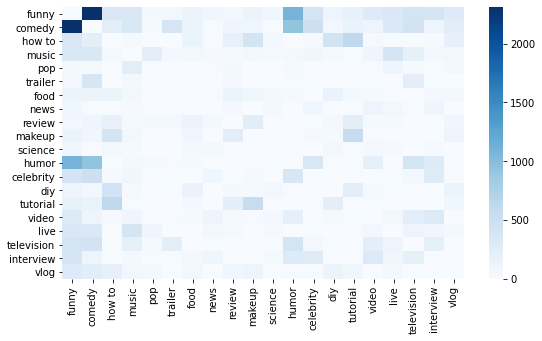

In [73]:
tags_start = 0
tags_end = 20

def boolean_df(item_lists, items):
    bool_dict={}
    for i, item in enumerate(items):
        bool_dict[item] = item_lists.apply(lambda x: item in x)
    return pd.DataFrame(bool_dict)

unique_items = tag_counts.head(tags_end).tail(tags_end-tags_start).index
tags_int = boolean_df(df['parsed_tags'], unique_items).astype(int)
tags_freq_mat = np.dot(tags_int.T, tags_int)
np.fill_diagonal(tags_freq_mat, 0) # Used to filter self correlations to increase visibility
tags_freq = pd.DataFrame(tags_freq_mat, columns = unique_items, index = unique_items)

fix, ax = plt.subplots(figsize = (9,5))
sns.heatmap(tags_freq, cmap = "Blues")
#plt.savefig("heatmap.png", dpi = 300)

## Calculate Tag factors
Each tag is assigned a factor that defines how good it contributes to reaching a high *trending_category*.
The resulting value is mapped onto the scale between 0 and 1 where 0 means low or no contribution
and 1 the highest contribution.
### Gather Tag Data

In [74]:
factors = {
    0 : 1.0,
    1 : 0.75,
    2 : 0.5,
    3 : 0.25,
    4 : 0.0
}

tag_index = {}
for index, row in df.iterrows():
    cat = row['trending_category']
    trending_value = factors[cat]
    for tag in row['parsed_tags']:
        if tag in tag_index:
            tag_index[tag]['count'] += 1
            tag_index[tag]['sum'] += trending_value
        else:
            tag_index[tag] = { 'count': 1, 'sum': trending_value }

tag_data = pd.DataFrame.from_dict(tag_index, orient='index')
tag_data

,count,sum
shantell martin,11,3.25
last week tonight trump presidency,7,2.00
last week tonight donald trump,7,2.00
john oliver trump,15,4.00
donald trump,307,88.25
...,...,...
best smashburgers,1,0.50
hamburger recipe,1,0.50
how to make hamburgers,1,0.50
best hamburger,1,0.50


### Filter Data and calculate Factor
The problem of the tag data is, that not each tag can be used for the calculation because there is not enough data about it.
Therefore, two parameterized limitations are introduced.

The first method is a filtering by either picking a fixed number of tags (based on usage), or a certain
percentage of all tags. The second method is a limitation based on how often a tag is used to ascertain a minimum of
entries for the evaluation.

The results are stored in a separate table for later calculation.

Note: The column *tag_weight* is added for comparison purposes and has no real meaning.

In [75]:
filtered_tag_factors = tag_data.copy()

if limit_method == 'count':
    filtered_tag_factors = filtered_tag_factors.head(max_tag_count)
elif limit_method == 'percent':
    filtered_tag_factors = filtered_tag_factors.head(int(len(filtered_tag_factors)*max_tag_percent))
else:
    filtered_tag_factors = filtered_tag_factors.copy()

if filter_tags_by_usage:
    filtered_tag_factors = filtered_tag_factors[filtered_tag_factors['count'] >= min_tag_usage]

filtered_tag_factors['factor'] = filtered_tag_factors['sum'] / filtered_tag_factors['count']
filtered_tag_factors['tag_weight'] = filtered_tag_factors['factor'] * filtered_tag_factors['count']
filtered_tag_factors = filtered_tag_factors.sort_values(by='factor', ascending=False)
filtered_tag_factors

,count,sum,factor,tag_weight
the roots,23,12.75,0.554348,12.75
espn nba,28,14.75,0.526786,14.75
nba on espn,24,12.50,0.520833,12.50
plvahqwmqn4m1uq5jitdkmnrxznwtug-dp,39,20.00,0.512821,20.00
nba finals,22,11.25,0.511364,11.25
...,...,...,...,...
white spider,24,0.00,0.000000,0.00
amv,24,0.00,0.000000,0.00
animated short,24,0.00,0.000000,0.00
thesis film,24,0.00,0.000000,0.00


### Factor based on usage limit
Choosing the correct values to filter the tags can be difficult. This section displays how the resulting
factors change based on a *usage limitation* between 1 and 1000.

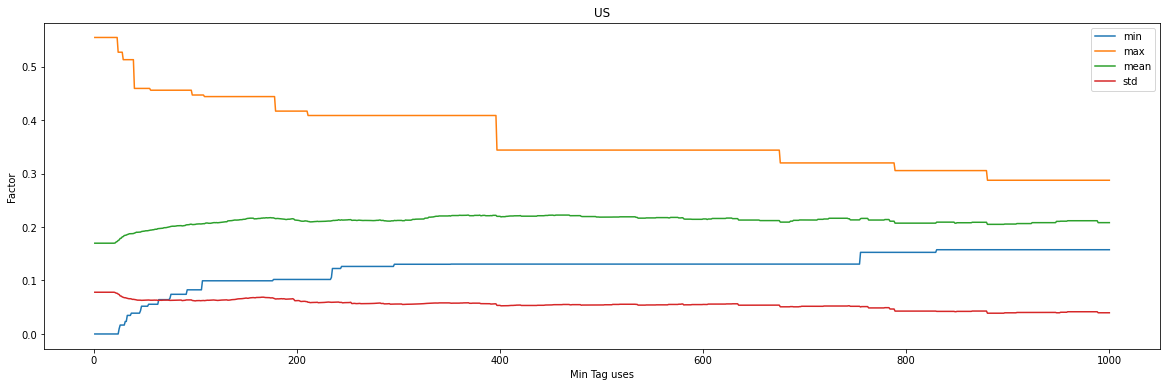

In [84]:
tag_stat = pd.DataFrame(columns=tag_data.describe().index )

for i in range(1,1001,1):
    data = tag_data[tag_data['count'] >= i]
    factor_data = data['sum'] / data['count']
    stat = factor_data.describe()
    stat.name = i
    tag_stat = tag_stat.append(stat)
fig = sns.lineplot(data = tag_stat[['min','max','mean','std']], dashes=False)
plt.xlabel("Min Tag uses")
plt.ylabel("Factor")
plt.title(data_lan_code)

#plt.savefig('stats'+data_lan_code+'.png', dpi = 300)
#tag_stat.to_csv('tag_stats_' + data_lan_code + '.csv')

plt.show(fig)

### Apply Tag factors
The calculated factors are applied back to the used data. If a video has multiple tags
the **mean** over all of them is used.

In [77]:
def calculate_tag_factor(data):
    tag_list = list()
    for t in data:
        factor = filtered_tag_factors['factor'].get(t, None)
        if factor is not None :
            tag_list.append(factor)
    return np.nan if len(tag_list) == 0 else np.mean(tag_list)
df['tag_factor'] = df['parsed_tags'].apply(calculate_tag_factor)

df[['title','tag_factor']]

,title,tag_factor
0,WE WANT TO TALK ABOUT OUR MARRIAGE,NaN
1,The Trump Presidency: Last Week Tonight with J...,0.287459
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",0.160649
3,Nickelback Lyrics: Real or Fake?,0.222322
4,I Dare You: GOING BALD!?,0.158517
...,...,...
40944,The Cat Who Caught the Laser,0.128234
40945,True Facts : Ant Mutualism,NaN
40946,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,0.110300
40947,How Black Panther Should Have Ended,0.165798


### Remove entries without value and sort by factor
If either not all tags of the data are used for the calculation, or some videos have no tags at all
the calculated factor equals *NaN*. Here these "invalid" rows are filtered out. Additionally, the data is
sorted by their factor to show the best results.

In [78]:
target_videos = df[df['tag_factor'].notna()]
target_videos[['video_id','title','tag_factor', 'tag_count']].sort_values(by=['tag_factor'], ascending=False)

,video_id,title,tag_factor,tag_count
7859,PitmObjGur4,Dick Enberg dies at 82 | SportsCenter | ESPN,0.430020,5
38959,C0KnxhQMLBU,Stephen A. Smith goes off after Game 2: It's t...,0.427279,28
39381,C0KnxhQMLBU,Stephen A. Smith goes off after Game 2: It's t...,0.427279,28
39173,C0KnxhQMLBU,Stephen A. Smith goes off after Game 2: It's t...,0.427279,28
25165,22iCU_bsApA,First Take interviews Trae Young after he decl...,0.419570,21
...,...,...,...,...
37103,tjA7nAHOAww,"LSD - Audio (Official Video) ft. Sia, Diplo, L...",0.019459,30
36272,tjA7nAHOAww,"LSD - Audio (Official Video) ft. Sia, Diplo, L...",0.019459,30
35431,tjA7nAHOAww,"LSD - Audio ft. Sia, Diplo, Labrinth",0.019459,30
37918,tjA7nAHOAww,"LSD - Audio (Official Video) ft. Sia, Diplo, L...",0.019459,30


### Data coverage
Due to the filtering some data is lost.

In [79]:
len(target_videos.index) / len(df.index)

0.9353341961952673

### Save tag factors to csv
The calculated factors are saved into a *csv* file to be used in the other notebooks.

In [80]:
tag_data = filtered_tag_factors.copy()
tag_data['tags'] = tag_data.index
tag_data[['tags','factor','count']].to_csv('../0_data/'+data_lan_code+'tags.csv', header=['tag','factor','count'], index=False)

## Loading and Testing data
To check if the data can be retrieved in the same way as it was stored.

The index of the table needs to be set manually after loading due to technical limitation of the *csv*-Format.

In [81]:
tag_df = pd.read_csv('../0_data/'+data_lan_code+'tags.csv')
tag_df = tag_df.set_index('tag')
tag_df.head()

,factor,count
tag,,
the roots,0.554348,23
espn nba,0.526786,28
nba on espn,0.520833,24
plvahqwmqn4m1uq5jitdkmnrxznwtug-dp,0.512821,39
nba finals,0.511364,22


### Converter function
This function can be used to calculate the tag factor based on the unparsed tag data. Values that are
not part of the given factor data will be excluded.

Note: If used inside PyCharm the editor may display a warning for this function which is a false positive,
the function is working as intended.

In [82]:
def calculate_tag_factor(tag_string, tag_values):
    return pd.Series(list(set(map(lambda x: x.strip('\"').lower(), tag_string.split('|')))))\
        .apply(lambda n: tag_values['factor'].get(n, np.nan))\
        .mean(skipna=True)

### Test converter function
Test the function and compare it to the calculated factors above.

In [83]:
test_df = pd.read_csv('../0_data/'+data_lan_code+'videos.csv')
test_df = test_df.head(10) # Just use head to reduce runtime
test_df['tag_factors'] = test_df['tags'].apply(lambda x: calculate_tag_factor(x, tag_df))
test_df[['video_id','title','channel_title','tags','tag_factors']]

,video_id,title,channel_title,tags,tag_factors
0,2kyS6SvSYSE,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,SHANtell martin,NaN
1,1ZAPwfrtAFY,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,"last week tonight trump presidency|""last week ...",0.287459
2,5qpjK5DgCt4,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",0.160649
3,puqaWrEC7tY,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,"rhett and link|""gmm""|""good mythical morning""|""...",0.222322
4,d380meD0W0M,I Dare You: GOING BALD!?,nigahiga,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",0.158517
5,gHZ1Qz0KiKM,2 Weeks with iPhone X,iJustine,"ijustine|""week with iPhone X""|""iphone x""|""appl...",0.216093
6,39idVpFF7NQ,Roy Moore & Jeff Sessions Cold Open - SNL,Saturday Night Live,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",0.252062
7,nc99ccSXST0,5 Ice Cream Gadgets put to the Test,CrazyRussianHacker,"5 Ice Cream Gadgets|""Ice Cream""|""Cream Sandwic...",0.170529
8,jr9QtXwC9vc,The Greatest Showman | Official Trailer 2 [HD]...,20th Century Fox,"Trailer|""Hugh Jackman""|""Michelle Williams""|""Za...",0.190162
9,TUmyygCMMGA,Why the rise of the robots won’t mean the end ...,Vox,"vox.com|""vox""|""explain""|""shift change""|""future...",0.252532
